# Midterm 1 on the Ising model

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import lines
import matplotlib.patches as mpatches

import tqdm.notebook # Progress bar for loops
import numba as nb

# Import user written module
import ising_1d as ising

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Plot settings
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('axes', axisbelow=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define parameter values and set seed

In [17]:
N = 1000
x_axis = range(N) # This is used to plot the lattice configuration

# Iteration parameters
n_max = 10000
n_0 = 8000

## Initial run

Run metropolis hastings and plot the resulting configuration and time series of magnetization

In [6]:
# Initialize
config = ising.initialstate(N)
energy_vec = np.empty(n_max)
mag_vec = np.empty(n_max)
beta = 1

# Perform n_max Monte Carlo steps
for i in range(n_max) :

    # Energy per site and average magnetization
    energy_vec[i] = ising.calcEnergy(config)
    mag_vec[i] = ising.calcMag(config)
    
    # Perform MC move
    ising.montecarlo(config, beta)

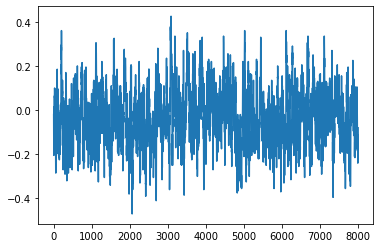

In [8]:
plt.plot(mag_vec)

Run the same procedure for the random neighbour model

In [18]:
# Initialize
config2 = ising.initialstate(N)
energy_vec = np.empty(n_max)
mag_vec = np.empty(n_max)
beta = 1/2 # Find some reasonable value

# Perform n_max Monte Carlo steps
for i in range(n_max) :

    # Energy per site and average magnetization
    energy_vec[i] = ising.calcEnergy(config2)
    mag_vec[i] = ising.calcMag(config2)
    
    # Perform MC move
    ising.montecarlo_random(config2, beta)

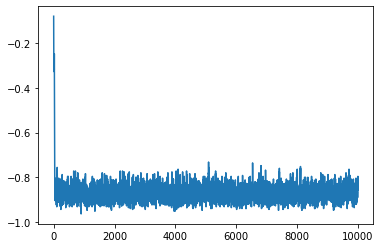

In [19]:
plt.plot(energy_vec)

## Magnetization as a function of temperature

In [20]:
################
## Initialize ##
################

kbT_vec = np.linspace(0.5, 3.5, 50) # Vector of values of inverse beta
energy_vec_kbT = np.empty((2, len(kbT_vec)))
mag_vec_kbT = np.empty((2, len(kbT_vec)))
config = np.empty((2,N))

#####################
## Run Monte Carlo ##
#####################

# Standard model
for i,kbT in enumerate(kbT_vec):

    # Initialize    
    config[0] = ising.initialstate(N)
    mag_temp = np.zeros(n_max - (n_0 + 1)) + np.nan
    
    # Beta is the inverse temperature
    beta_val = 1.0/kbT

    # run MC-MC
    for it in range(n_max):

        # Run Monte Carlo
        ising.montecarlo(config[0], beta_val)

        # Begin to store data after n0 mc steps
        if it > n_0:
            mag_temp[it - n_0 - 1] = ising.calcMag(config[0])

    # Save the resulting energy and magnetization
    mag_vec_kbT[0,i] = np.abs(np.mean(mag_temp)) # Calculate the absolute magnetization as the solution is symmetric
    

# Random neighbour model
for i,kbT in enumerate(kbT_vec):

    # Initialize
    config[1] = ising.initialstate(N) # Random neighbour
    mag_temp = np.zeros(n_max - (n_0 + 1)) + np.nan
    
    # Beta is the inverse temperature
    beta_val = 1.0/kbT

    # run MC-MC
    for it in range(n_max):

        # Run Monte Carlo
        ising.montecarlo_random(config[1], beta_val)

        # Begin to store data after n0 mc steps
        if it > n_0:
            mag_temp[it - n_0 - 1] = ising.calcMag(config[1])

    # Save the resulting energy and magnetization
    mag_vec_kbT[1,i] = np.abs(np.mean(mag_temp)) # Calculate the absolute magnetization as the solution is symmetric

Plot results

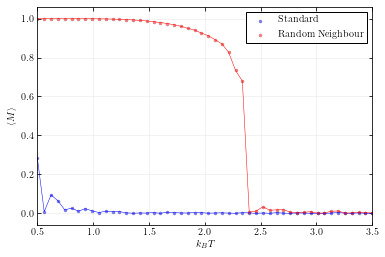

In [32]:
# Initialize figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Standard model
ax.plot(kbT_vec, mag_vec_kbT[0,:], linewidth = 0.5, color = 'blue', linestyle = '-')
ax.scatter(kbT_vec, mag_vec_kbT[0,:], color = 'blue', alpha = 0.5, s = 10, edgecolor='k', linewidth = 0.2, label='Standard')

# Random neighbour model
std1 = ax.plot(kbT_vec, mag_vec_kbT[1,:], linewidth = 0.5, color = 'red', linestyle = '-')
std2 = ax.scatter(kbT_vec, mag_vec_kbT[1,:], color = 'red', s = 10, alpha=0.5, edgecolor = 'k', linewidth= 0.2, label = 'Random Neighbour')

# ax.set_title('Magnetization per Site')
rnd1 = ax.set_xlabel('$k_B T$')
rnd2 = ax.set_ylabel('$\\langle M \\rangle$')

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.set_xlim(0.5,3.5)

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../midterm_1/magnetization.pdf')

## Estimate the critical temperature 

In [22]:
################
## Initialize ##
################

temperature = np.linspace(2.4, 3.8, 20) # Vector of values of inverse beta
temperature_reverse = temperature[::-1]

N_vals = np.linspace(500, 5000, 20)
mag = np.empty((len(N_vals),len(temperature))) + np.nan
T_c = np.empty(len(N_vals)) + np.nan
               
#####################
## Run Monte Carlo ##
#####################
for i,N_i in enumerate(N_vals):
    for j,kbT in enumerate(temperature):
        
        N = np.int(np.rint(N_i))
        
        # Initialize with N_i sites
        state = ising.initialstate(N)
        mag_temp = np.zeros(n_max - (n_0 + 1)) + np.nan
        
        # Beta is the inverse temperature
        beta_val = 1.0/kbT

        # Run MC-MC
        for it in range(n_max):

            # Run Monte Carlo
            ising.montecarlo_random(state, beta_val)

            # Begin to store data after n0 mc steps
            if it > n_0:
                mag_temp[it - n_0 - 1] = np.mean(state)

        # Save the resulting energy and magnetization
        mag[i,j] = np.abs(np.mean(mag_temp)) # Calculate the absolute magnetization as the solution is symmetric

In [43]:
# Compute the critical temperature
mag_reverse = np.flip(mag, axis=1)
T_c = np.empty(len(N_vals)) + np.nan

for i in range(len(N_vals)):
    for j in range(len(temperature)):
        
        # Stop when magnetization is positive, for a given N
        if mag_reverse[i,j] > 0.01:
            T_c[i] = (temperature_reverse[j] + temperature_reverse[j-1])/2

            break

Estimate best linear fit

In [48]:
N_inv = 1/N_vals

alpha_1 = np.cov(T_c, N_inv)[1,0] / np.var(N_inv)
alpha_0 = np.mean(T_c - alpha_1*N_inv)
fitted = alpha_0 + alpha_1*N_inv

print(alpha_0)
print(alpha_1)

2.5679769669570303
381.35741549366145


Plot the results

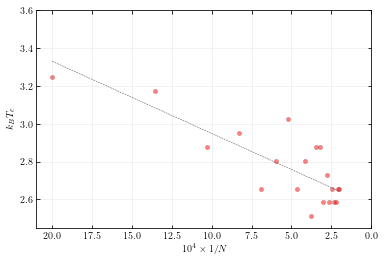

In [49]:
N_inv = 1/N_vals
amplification = 1e+4

# Initialize figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Random neighbour model
# ax.plot(kbT_vec, mag_vec_kbT[1,:], linewidth = 0.5, color = 'red', linestyle = '-')
ax.scatter(amplification*N_inv, T_c, color = 'red', s = 20, alpha = 0.5, edgecolor = 'k', linewidth= 0.2)
ax.plot(amplification*N_inv, fitted, linewidth = 0.5, color = '0.3', linestyle = '--')

ax.set_xlabel(r'$10^{4} \times 1/N$')
ax.set_ylabel('$k_B T_c$')

ax.set_xlim(21,0)
ax.set_ylim(2.45,3.6)

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../midterm_1/T_c.pdf')